In [117]:
import numpy as np
import pandas as pd
import qml
import scipy.spatial as scs
import glob
import scipy.interpolate as sci
import functools
import matplotlib.pyplot as plt
%load_ext line_profiler
c = qml.Compound('../../test/c20.xyz')
from pymatgen.symmetry import analyzer as psa
from pymatgen.core import Molecule

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [221]:
def build_cache():
    mol = Molecule(c.nuclear_charges, c.coordinates)
    a = psa.PointGroupAnalyzer(mol)
    cache = []
    for symop in a.get_symmetry_operations():
        newcoord = symop.operate_multi(c.coordinates)
        ds = scs.distance.cdist(c.coordinates, newcoord)
        f, t = np.where(np.round(ds, 2) == 0.)
        cache.append(t)
    return cache
def get_rotation_single(origin, target):
    return ROTCACHE[ROTCACHE[:, target] == origin][0]
def get_rotation_pair(origin1, origin2, target1, target2):
    return ROTCACHE[(ROTCACHE[:, target1] == origin1) & (ROTCACHE[:, target2] == origin2)][0]

In [222]:
def get_nucnuc(zs):
    ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))*1.8897259885789
    q = np.outer(zs, zs)/ds
    np.fill_diagonal(q, 0)
    return q.sum()/2
def coefficient_matrix():
    result = np.zeros((20, 13))
    lastgrid = None
    lastweights = None
    for fidx, fn in enumerate(FNS):
        _, a, b = read_DENSITY_cached(fn)
        if lastgrid is not None:
            assert np.allclose(_, lastgrid)
            assert np.allclose(a, lastweights)
        lastgrid = _
        lastweights=a
        for j in range(20):
            ds = get_grid_ds(j)/1.8897259885789
            result[j, fidx] = (a*b*ds).sum()
    return result
FNS = '''c20-data/derivatives/order-0/site-all-cc/DENSITY
c20-data/derivatives/order-1/site-0-dn/DENSITY
c20-data/derivatives/order-1/site-0-up/DENSITY
c20-data/derivatives/order-2/site-0-1-dn/DENSITY
c20-data/derivatives/order-2/site-0-1-up/DENSITY
c20-data/derivatives/order-2/site-0-10-dn/DENSITY
c20-data/derivatives/order-2/site-0-10-up/DENSITY
c20-data/derivatives/order-2/site-0-16-dn/DENSITY
c20-data/derivatives/order-2/site-0-16-up/DENSITY
c20-data/derivatives/order-2/site-0-2-dn/DENSITY
c20-data/derivatives/order-2/site-0-2-up/DENSITY
c20-data/derivatives/order-2/site-0-8-dn/DENSITY
c20-data/derivatives/order-2/site-0-8-up/DENSITY'''.split('\n')
def symbolic_read_density(fn):
    return FNS.index(fn)
@functools.lru_cache(maxsize=20*20)
def symbolic_get_deriv(i, j):
    """ Returns 
    t_i : atom index of i after rotation
    t_j : atom index of j after rotation
    deriv_pair : the density to be integrated after pairwise rotation
    deriv_single : density to be integrated after single rotation """
    
    if i != j:
        d = np.linalg.norm(c.coordinates[i] - c.coordinates[j])
        geo = np.argmin(np.abs(np.array(sorted(set(np.round(scs.distance.pdist(c.coordinates), 2)))) - d))
        sites = (0, (1, 2, 8, 10, 16)[geo])
        i, j = sites
    delta = 0.05
    deriv_single = np.zeros(13)
    deriv_pair = np.zeros(13)
    
    mid = symbolic_read_density('c20-data/derivatives/order-0/site-all-cc/DENSITY')
    iup = symbolic_read_density('c20-data/derivatives/order-1/site-0-up/DENSITY')
    idn = symbolic_read_density('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    if i == j:
        deriv_single[iup] = 1/(delta**2)
        deriv_single[idn] = 1/(delta**2)
        deriv_single[mid] = -2/(delta**2)
    else:
        jup = iup
        jdn = idn
        up = symbolic_read_density('c20-data/derivatives/order-2/site-0-%d-up/DENSITY' % j)
        dn = symbolic_read_density('c20-data/derivatives/order-2/site-0-%d-dn/DENSITY' % j)
        
        deriv_pair[up] = 1/ (2 * delta**2)
        deriv_pair[dn] = 1/ (2 * delta**2)
        deriv_pair[mid] = 2/ (2 * delta**2)
        deriv_pair[iup] = -1/ (2 * delta**2)
        deriv_pair[idn] = -1/ (2 * delta**2)
        
        deriv_single[jup] = -1/ (2 * delta**2)
        deriv_single[jdn] = -1/ (2 * delta**2)
    
    return i, j, deriv_pair/6, deriv_single/6
def symbolic_read_grid_first_order():
    changed_site = 0
    delta = 0.05
    
    up = symbolic_read_density('c20-data/derivatives/order-1/site-0-up/DENSITY')
    dn = symbolic_read_density('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    deriv_single = np.zeros(13)
    deriv_single[up] = 1/(2*delta)
    deriv_single[dn] = -1/(2*delta)
    
    return changed_site, deriv_single/2
def read_grid_first_order():
    changed_site = 0
    delta = 0.1
    
    upgrid, upweight, updens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-up/DENSITY')
    dngrid, dnweight, dndens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    
    if not np.allclose(upgrid, dngrid):
        raise ValueError('Grid?')
        
    if not np.allclose(upweight, dnweight):
        raise ValueError('Grid?')
    
    return changed_site, upgrid, ((updens - dndens) / delta)*upweight
def read_DENSITY(fn):
    with open(fn, 'r') as fh:
        _ = np.fromfile(fh, 'i4')
        q = _[3:-1].view(np.float64)
        ccdensity = q.reshape((-1, 10))
    ccdensity = ccdensity[:, 1:6]
    return ccdensity[:, :3]/1.8897259885789, ccdensity[:, 3], ccdensity[:, 4]
def read_CCSD():
    res = []
    atomE = {'5': -24.561351362788, '6': -37.714812342283, '7': -54.418867578066}
    for fn in glob.glob('validation/CCSD/*/run.log'):
        with open(fn) as fh:
            lines = fh.readlines()[::-1]
            for line in lines:
                if line.startswith(' Total CCSD energy [au]:'):
                    energy = float(line.strip().split()[-1])
                    target = fn.split('/')[-2]
                    atomisation = energy - sum([atomE[_] for _ in target])
                    res.append({'target': target, 'CCSD': energy, 'CCSDatom': atomisation})
                    break
    return pd.DataFrame(res)
df_ccsd = read_CCSD()

In [143]:
@functools.lru_cache(maxsize=20*20*20*20)
def build_reindexing_2_cached(a, b, c, d):
    return build_reindexing_2_merged(a, b, c,d)
@functools.lru_cache(maxsize=20*20*20*20)
def build_reindexing_1_cached(a, b):
    return build_reindexing_1_merged(a, b)
@functools.lru_cache(200)
def read_DENSITY_cached(fn):
    return read_DENSITY(fn)
@functools.lru_cache(30)
def get_grid_ds(j):
    return 1/(np.linalg.norm(grid_points*1.8897259885789 - c.coordinates[j]*1.8897259885789, axis=1))
@functools.lru_cache(maxsize=20*20)
def get_deriv_cached(i, j):
    return get_deriv(i, j)
changed_site, grid_points, grid_densweight = read_grid_first_order()
ROTCACHE = np.array(build_cache())
COEFFMAT = coefficient_matrix()

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0 1 1.6472891954717852
1.2097751749306553 1.6472891954717852
0 2 -1.7302872241989462
-3.189269895628968 -1.7302872241989462
0 3 0.85935989500922
1.3528235438193406 0.85935989500922
0 4 -15.263749511592778
3.2709076593564532 -15.263749511592778
0 5 -3.5260898511942287
1.4781396474108988 -3.5260898511942287
0 6 -0.9581597428123132
0.5180096312105889 -0.9581597428123132
0 7 -4.914769184620127
2.913899936214875 -4.914769184620127
0 8 -2.3307246689455496
-2.0823795677097223 -2.3307246689455496
0 9 -3.309231073664705
-0.7963675602377407 -3.309231073664705
0 10 -0.955161241751739
-3.032583448587957 -0.955161241751739
0 11 -1.4282028566562985
-0.4524931199521234 -1.4282028566562985
0 12 4.128744810772787
-0.957731934907315 4.128744810772787
0 13 -3.007840880353797
-1.644834611686747 -3.007840880353797
0 14 -4.374803202953444
0.4339338812415008 -4.374803202953444
0 15 0.6185401687544072
-3.196838887074591 0.6185401687544072
0 16 1.0756540695238073
-0.4566832850523497 1.0756540695238073
0 17 3.7

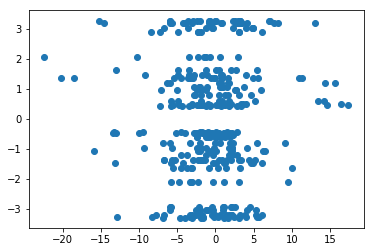

In [265]:
def symbolic_get_predictions(comb):
    result = {}
    result['ref'] = -758.072029908548
    
    deltaZ = np.array(comb) - 6
        
    zs = np.array([int(_) for _ in comb])
    zsref = np.zeros(20) + 6
    result['deltaNN'] = get_nucnuc(zs) - get_nucnuc(zsref)
    
    # collect terms to evaluate, shape (density x atoms)
    coefficients = np.zeros((20, 13))
    
    # 0-th order, no rotation necessary, should be hard zero, might not be due to asymmetry
    zero_coefficients = np.zeros(13)
    zero_coefficients[0] = 1
    result['order0'] = np.multiply(np.outer(deltaZ, zero_coefficients), COEFFMAT).sum()
    
    # 1st order
    changed_site, this_coefficients = symbolic_read_grid_first_order()
    for idx in range(20):
        if deltaZ[idx] != 0:
            mapping = get_rotation_single(idx, changed_site)
            
            #assert (deltaZ[mapping][0] == deltaZ[idx])
            assert (mapping[0] == idx)
            assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
            
            coefficients -= deltaZ[idx] * np.outer(deltaZ[mapping], this_coefficients)
    
    result['order1'] = np.multiply(coefficients,COEFFMAT).sum()
    
    # debug
    debugp = []
    debugs = []
    
    # 2nd order
    coefficients = np.zeros((20, 13))
    outercache = np.zeros(coefficients.shape)
    del idx
    for idx_i in range(20):
        if deltaZ[idx_i] != 0:
            for idx_j in range(20):
                if deltaZ[idx_j] != 0:
                    # t_i: target for idx_i after rotation
                    # deriv_pair: part of derivative after pair-mapping
                    # deriv_single: part of derivative after single-mapping
                    t_i, t_j, deriv_pair, deriv_single = symbolic_get_deriv(idx_i, idx_j)
                    if idx_i != idx_j:
                        assert (t_j != 0)

                    # pairwise mapping
                    if idx_i != idx_j:
                        mapping = get_rotation_pair(idx_i, idx_j, t_i, t_j)

                        assert (mapping[t_i] == idx_i)
                        assert (mapping[t_j] == idx_j)
                        assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
                        
                        np.outer(deltaZ[mapping], deriv_pair, out=outercache)
                        change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
                        debugp.append(np.multiply(change, COEFFMAT).sum())
                        print (idx_i, idx_j, np.multiply(change, COEFFMAT).sum())
                        coefficients += change

                    # single mapping
                    mapping = get_rotation_single(idx_j, 0)
                    assert (deltaZ[mapping][0] != 0)
                    assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
                    np.outer(deltaZ[mapping], deriv_single, out=outercache)
                    change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
                    if idx_i != idx_j:
                        debugs.append ( np.multiply(change, COEFFMAT).sum())
                        print (debugs[-1], debugp[-1])
                    coefficients += change 
    
    result['order2'] = np.multiply(coefficients,COEFFMAT).sum()
    
    result['prediction'] = result['ref'] + result['order0'] + result['order1'] + result['order2']  + result['deltaNN']
    result['target'] = ''.join([str(_) for _ in comb])
    return debugp, debugs # result
#print (symbolic_get_predictions([int(_) for _ in '75666666666666666666']))
a, b = (symbolic_get_predictions([int(_) for _ in '55555555775777777577']))
plt.scatter(a, b)

In [233]:
def get_predictions():
    ret = []
    for val in df_ccsd.target.values[::10]:
        try:
            q = symbolic_get_predictions([int(_) for _ in val])
        except:
            print (val)
            raise
        q['bnpairs'] = len([_ for _ in val if _ =='5'])
        ret.append(q)
    def atomisation(row):
        atomE = {'5': -23.624308208720, '6': -37.714812342283, '7': -52.831420359950}
        a = sum([atomE[_] for _ in row['target']])
        return a
    df = pd.DataFrame(ret)
    df['atomisation'] = df.apply(atomisation, axis=1)
    q = pd.merge(df, df_ccsd, how='inner')
    return q

In [234]:
predictions = get_predictions()

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


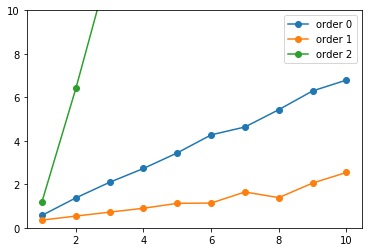

In [235]:
predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0 - predictions.atomisation - predictions.CCSDatom)
q = predictions.groupby('bnpairs').mean().reset_index()
plt.plot(q.bnpairs, q.error, 'o-', label='order 0')

predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0+ predictions.order1 - predictions.atomisation - predictions.CCSDatom)
q = predictions.groupby('bnpairs').mean().reset_index()
plt.plot(q.bnpairs, q.error, 'o-', label='order 1')

predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0+ predictions.order1+ predictions.order2 - predictions.atomisation - predictions.CCSDatom)
q = predictions.groupby('bnpairs').mean().reset_index()
plt.plot(q.bnpairs, q.error, 'o-', label='order 2')

plt.ylim(0, 10)
plt.legend()

In [254]:
symbolic_get_deriv(19, 10)
#1/(0.05**2)/6
#list(enumerate(FNS))

(0, 8, array([ 66.66666667, -33.33333333, -33.33333333,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  33.33333333,
         33.33333333]), array([  0.        , -33.33333333, -33.33333333,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]))

0-up
-2mid
0-dn

08
pair:
0  1  2 3 4 5 6 7 8 9 0 1 2
2 -1 -1                 1 1
single
0 -1 -1 0 0 0 0 0 0 0 0 0 0